<font size=7, color='darkblue'>EDA of the __King County Housing__ dataset</font>

----


# Overview

### the client: 
> a buyer, who wants to know the best timing to buy a house with these characteristics: <br>
> - lively, central neighborhood
> - mid-range price

### goal:
> - draw insights from the data through EDA
> - provide advice to the client

### data at hand:
> dataset containing house sale prices for King County, USA (homes sold between May 2014 and May 2015)

### data overview:
> - 21597 observations
> - 20 features

<br><br>
# King County on the map

In [1]:
from IPython.display import Image
Image(url="https://kingcounty.gov/~/media/about/maps/KC_simplemap_Oct2013.ashx?la=en")

<br><br>
# Table of Contents

1. [Understanding the Data](#1.-Understanding-the-Data)
2. [Research Questions and Hypotheses](#2.-Research-Questions-and-Hypotheses)
3. [Exploring the Data](#3.-Exploring-the-Data)
4. [Cleaning the Data](#4.-Cleaning-the-Data)
5. [Relationships in the Data](#5.-Relationships-in-the-Data)
6. [Results of the Analysis of the Hypotheses](#6.-Results-of-the-Analysis-of-the-Hypotheses)
7. [Insights and Recommendations for the Client](#7.-Insights-and-Recommendations-for-the-Client)


<br><br>
# Import libraries and load the data

In [2]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# import plotly
import plotly.figure_factory as ff
import plotly.express as px

# make sure the .mapbox_token file (containing the acsess key) is in the same folder as this Jupyter notebook
px.set_mapbox_access_token(open(".mapbox_token").read())

In [4]:
# import helper functions, written for this EDA
from helper_functions import outlier_bound, deg_to_dec, parse_text, haversine_distance

In [5]:
# load the data, let pandas convert the 'date' column into date-type
path = "data/housing.csv"
df = df_housing = pd.read_csv(path, parse_dates=['date'])

<br><br>
# 1. Understanding the Data

## hexbin plot of the data to visualize the density of datapoints

In [47]:
# get the mask (and dataframe) of non-duplicate houses
cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'yr_built', 'zipcode', 'lat', 'long']
mask_unique_houses = ~df.duplicated(subset=cols)  # 190 houses are duplicates
df_unique_houses = df[mask_unique_houses]

fig = ff.create_hexbin_mapbox(
    data_frame=df_unique_houses, 
    lat="lat", lon="long",
    nx_hexagon=30, opacity=0.8, labels={"color": "Point Count"},
)
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

# run this cell again if the hexbin plot is not displayed

## basic info and descriptive statistics

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   bedrooms       21597 non-null  float64       
 2   bathrooms      21597 non-null  float64       
 3   sqft_living    21597 non-null  float64       
 4   sqft_lot       21597 non-null  float64       
 5   floors         21597 non-null  float64       
 6   waterfront     19206 non-null  float64       
 7   view           21534 non-null  float64       
 8   condition      21597 non-null  int64         
 9   grade          21597 non-null  int64         
 10  sqft_above     21597 non-null  float64       
 11  sqft_basement  21145 non-null  float64       
 12  yr_built       21597 non-null  int64         
 13  yr_renovated   17749 non-null  float64       
 14  zipcode        21597 non-null  int64         
 15  lat            2159

<br>

* ### descriptive statistics on selected continuous features:

In [8]:
continuous_features = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price']
df[continuous_features].describe()

,sqft_living,sqft_lot,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,price
count,21597.000,21597.000,21597.000,21145.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,2080.322,15099.409,1788.597,291.857,47.560,-122.214,1986.620,12758.284,540296.574
std,918.106,41412.637,827.760,442.491,0.139,0.141,685.230,27274.442,367368.140
min,370.000,520.000,370.000,0.000,47.156,-122.519,399.000,651.000,78000.000
25%,1430.000,5040.000,1190.000,0.000,47.471,-122.328,1490.000,5100.000,322000.000
50%,1910.000,7618.000,1560.000,0.000,47.572,-122.231,1840.000,7620.000,450000.000
75%,2550.000,10685.000,2210.000,560.000,47.678,-122.125,2360.000,10083.000,645000.000
max,13540.000,1651359.000,9410.000,4820.000,47.778,-121.315,6210.000,871200.000,7700000.000


* ### values of some categorical and discrete features:

In [9]:
categorical_features = ['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'yr_built', 'zipcode']
for feature in categorical_features:
    print(feature+':', str(sorted(set(df[feature])))[1:-1], end='\n\n')

bedrooms: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 33.0

bathrooms: 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0

floors: 1.0, 1.5, 2.0, 2.5, 3.0, 3.5

condition: 1, 2, 3, 4, 5

grade: 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13

yr_built: 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 200

**_notes:_**
- values of **bedrooms** larger than 9 are apparently outliers - judging from the value counts
- decimal values of **bathrooms** are explained [here](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/discussion/24804)
- the values of the **grade** feature are clarified [here](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/discussion/23194)

## missing values

In [10]:
df.isnull().sum(axis=0)

id                  0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
date                0
price               0
dtype: int64

**_notes:_** <br>
it is not necessary to impute missing values or exclude rows with missing values in this particular EDA because the four features which contain missing values **waterfront**, **view**, **sqft_basement** and **yr_renovated** do not relate to our client's problem.

<br><br>
# 2. Research Questions and Hypotheses

_general research questions:_

**research question 1:**
> Are there strong correlations between certain features and the **price**?
> - Hypothesis: the actual Pearson correlation coefficient (of a certain variable) is different from zero <br>
> _(If necessary it is possible to test the significance of the correlation coefficient with **scipy.stats.pearsonr**)_


**research question 2:**
> Do the housing prices in the northern part of the county differ from the southern regions of King County?
> - Hypothesis: the average price in the south is different from the price in the north (t-test)

**research question 3:**
> Is the proportion of luxury houses dependent on the zipcode?
> - Hypothesis: the proportion of luxury houses is different in various zipcodes

<br>

_research questions for the client:_

**research question 4:**
> When is the best time to buy a house for the client?


**research question 5:**
> In which zipcodes does the client has a better chance to find a house in the mid range price, near the city center?

<br><br>
# 3. Exploring the Data

## distributions of continuous features

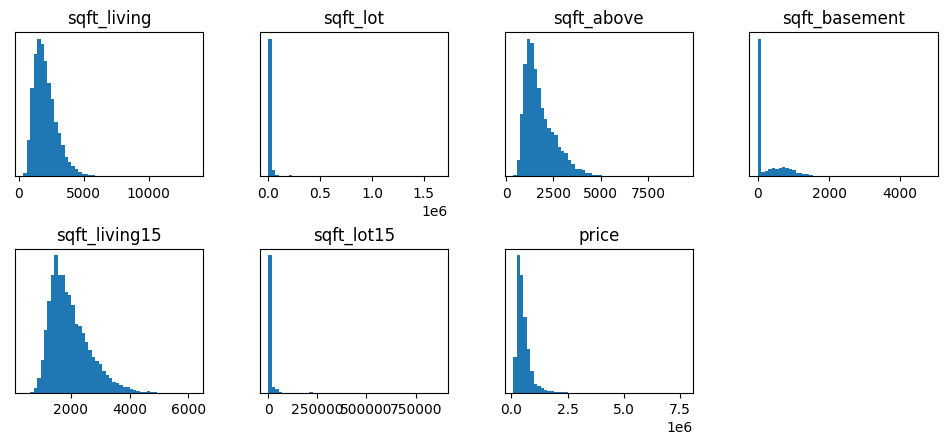

In [11]:
continuous_features = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price']

fig, axes = plt.subplots(2,4, figsize=(10,5))
fig.tight_layout() 
plt.subplots_adjust(hspace = .5, wspace = .3, top = .8)

axes = axes.ravel()

for i,feature in enumerate(continuous_features):
    axes[i].hist(df[feature], bins=50, density=True)
    axes[i].set_title(feature)
    axes[i].axes.get_yaxis().set_visible(False)

fig.delaxes(axes[-1])


**_note:_**
most of the distributions are (highly) positively skewed, which is an indication of outliers (a few very expensive, large houses)

## distributions for the categorical features

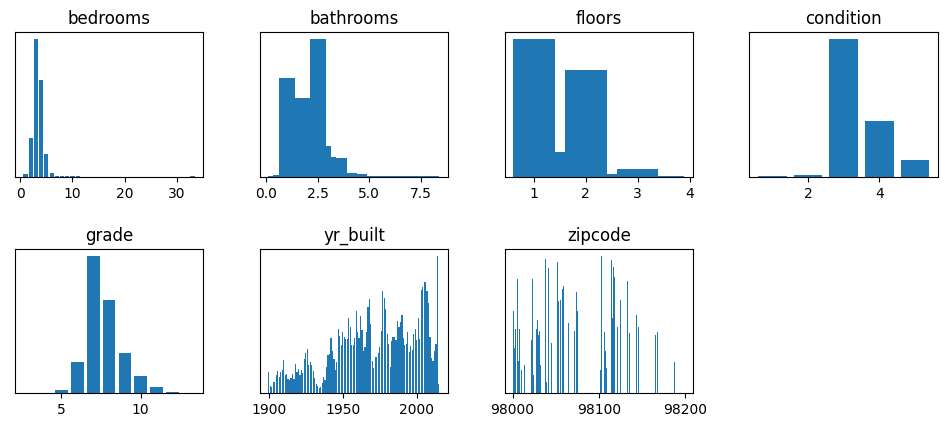

In [12]:
categorical_features = ['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'yr_built', 'zipcode']

fig, axes = plt.subplots(2,4, figsize=(10,5))
fig.tight_layout() 
plt.subplots_adjust(hspace = .5, wspace = .3, top = .8)

axes = axes.ravel()

for i,feature in enumerate(categorical_features):
    sr = df[feature].value_counts()
    axes[i].bar(x=sr.index.values, height=sr.values)
    axes[i].set_title(feature)
    axes[i].axes.get_yaxis().set_visible(False)

fig.delaxes(axes[-1])

## outliers and extreme values analysis

Let's get the descriptive statistics again and look for extreme values / outliers.
The **bedrooms** feature has been already identified as having a bogus value of 33.
Let's only include relevant features:

In [13]:
cols = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price']
df[cols].describe()

,bedrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,price
count,21597.000,21597.000,21597.000,21597.000,21145.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,3.373,2080.322,15099.409,1788.597,291.857,47.560,-122.214,1986.620,12758.284,540296.574
std,0.926,918.106,41412.637,827.760,442.491,0.139,0.141,685.230,27274.442,367368.140
min,1.000,370.000,520.000,370.000,0.000,47.156,-122.519,399.000,651.000,78000.000
25%,3.000,1430.000,5040.000,1190.000,0.000,47.471,-122.328,1490.000,5100.000,322000.000
50%,3.000,1910.000,7618.000,1560.000,0.000,47.572,-122.231,1840.000,7620.000,450000.000
75%,4.000,2550.000,10685.000,2210.000,560.000,47.678,-122.125,2360.000,10083.000,645000.000
max,33.000,13540.000,1651359.000,9410.000,4820.000,47.778,-121.315,6210.000,871200.000,7700000.000


* ### outlier analysis of feature: **bedrooms**

In [14]:
df.bedrooms.value_counts()

3.000     9824
4.000     6882
2.000     2760
5.000     1601
6.000      272
1.000      196
7.000       38
8.000       13
9.000        6
10.000       3
11.000       1
33.000       1
Name: bedrooms, dtype: int64

The **IQR*1.5** rule gives us the upper bound at 5.5. However let's just drop the rows with values 9 and greater. These are apparently isolated cases of large villas. We'll do that in the next session: Cleaning the Data

In [15]:
print("upper threashold for outliers in bedrooms:",  outlier_bound(df.bedrooms) )

upper threashold for outliers in bedrooms: 5.5


* ### outlier analysis of features: **sqft_living**, **sqft_lot**, **sqft_above**, **sqft_basement**

The min and max values seem plausible (did conversion into sq meters - values seem ok)

* ### outlier analysis of features: **lat**, **long**
The latitude and longitude values contain no bogus values. The coordinates lie within King County.

* ### outlier analysis of feature: **date**

In [16]:
# checking the dates for plausibility
df.date.min(), df.date.max()

(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

* ### outlier analysis of feature: **price**

In [17]:
upper_bound = outlier_bound(df.price)
print("upper bound for outliers in the price feature:", upper_bound)

upper bound for outliers in the price feature: 1129500.0


In [18]:
price_ouliers = df.query("price > @upper_bound").price.values
print("number of outliers according to the IQR+1.5 rule:", len(price_ouliers))

number of outliers according to the IQR+1.5 rule: 1158


However since log(price) is distributed almost normally, we can leave those extreme values, and use log(price) to model linear relationship in the future.  Besides, we will use quantiles to define "mid range price" for our client - so these extreme price values should not influence our analysis. 

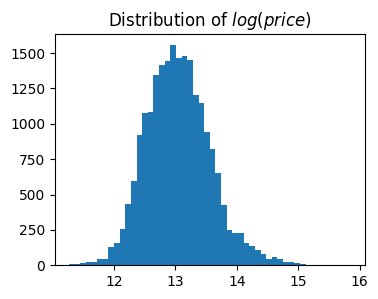

In [19]:
plt.figure(figsize=(4,3))
plt.hist(np.log(df.price), bins=50)
plt.title("Distribution of $log(price)$");

## missing values
as mentioned above the features which contain missing values do not affect this EDA, so the rows that contain missing values can be left in.

<br><br>
# 4. Cleaning the Data

## missing values

the only feature whose missing values can be sensibly imputed is **sqft_basement**:

In [20]:
# use the mean for imputation of the missing values in 'sqft_basement'
mu = df['sqft_basement'].mean()
df['sqft_basement'].fillna(mu, inplace=True)

because we don't need **waterfront**, **view** and **yr_renovated** for our EDA here, we can safely remove these columns:

In [21]:
df.dropna(axis='columns', how='any', inplace=True)

# now we got rid of all NaN's
df.isnull().sum(0)

id               0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
date             0
price            0
dtype: int64

## remove outliers

As descussed above, we are now removing the observations containing outliers in the **bedrooms** feature

In [22]:
# 11 observations are removed from the dataset
df = df[df.bedrooms < 9]

## convert applicable features to integers

In [23]:
# convert 'bedrooms' to int because this feature contains whole numbers
df['bedrooms'] = df['bedrooms'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21586 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21586 non-null  int64         
 1   bedrooms       21586 non-null  int64         
 2   bathrooms      21586 non-null  float64       
 3   sqft_living    21586 non-null  float64       
 4   sqft_lot       21586 non-null  float64       
 5   floors         21586 non-null  float64       
 6   condition      21586 non-null  int64         
 7   grade          21586 non-null  int64         
 8   sqft_above     21586 non-null  float64       
 9   sqft_basement  21586 non-null  float64       
 10  yr_built       21586 non-null  int64         
 11  zipcode        21586 non-null  int64         
 12  lat            21586 non-null  float64       
 13  long           21586 non-null  float64       
 14  sqft_living15  21586 non-null  float64       
 15  sqft_lot15     2158

<br><br>
# 5. Relationships in the Data

## Explore correlation between features
* ### visualize correlation

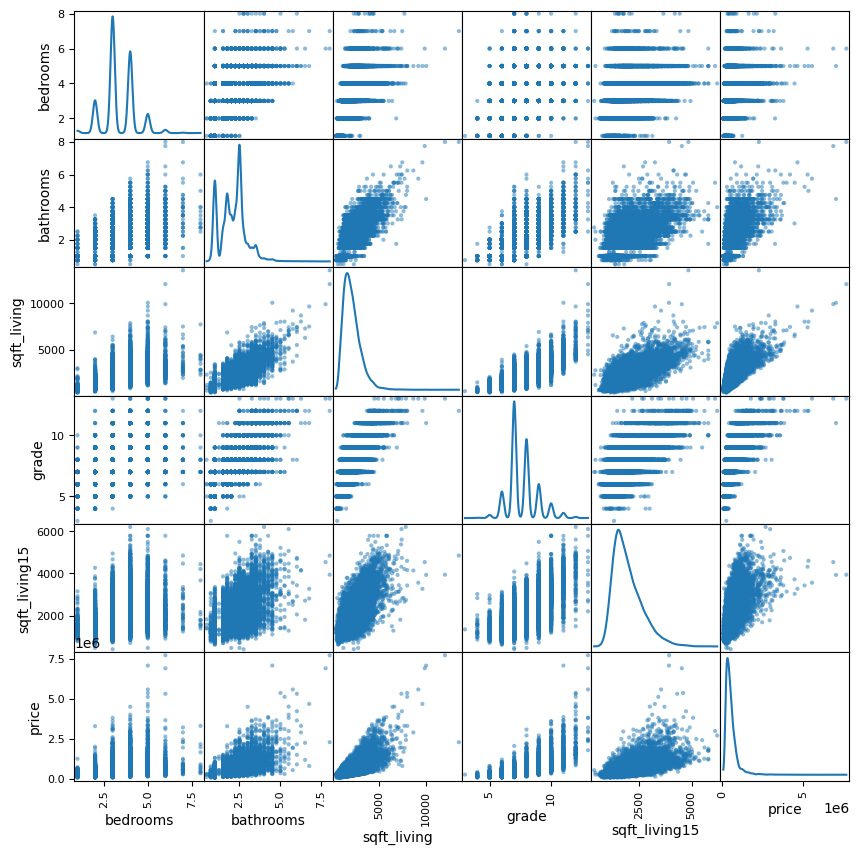

In [24]:
# use selected features (excluded those that show very low correlation)
features = ['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'price']
pd.plotting.scatter_matrix(df[features], diagonal='kde', figsize=(10,10));

* ### compute correlation matrix

In [25]:
cm = df[features].corr()
print("Correlation coefficients between features and price:", 
      cm.price.sort_values(key=abs, ascending=False)[1:],
      sep="\n\n")

Correlation coefficients between features and price:

sqft_living     0.702
grade           0.668
sqft_living15   0.585
bathrooms       0.526
bedrooms        0.317
Name: price, dtype: float64


* ### visualize the heatmap of correlation coefficients

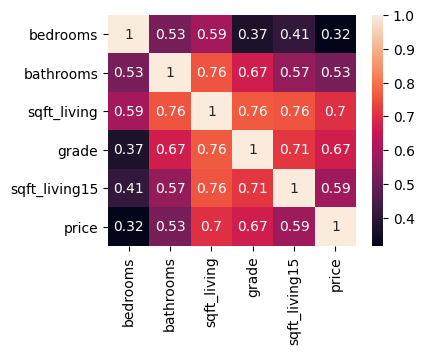

In [26]:
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True);

* ### visualize correlation between logs of some applicable features

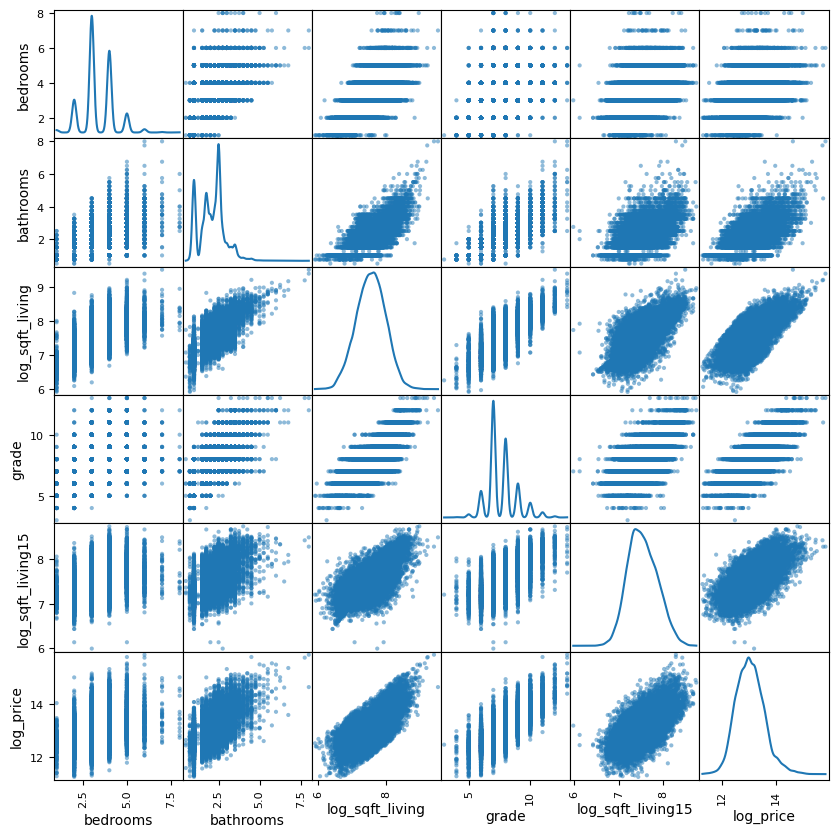

In [27]:
# take the log of some continuous features to make them look normally deistributed
df_logs = df.copy()
df_logs['log_price'] = np.log(df_logs.price)
df_logs['log_sqft_living'] = np.log(df_logs['sqft_living'])
df_logs['log_sqft_living15'] = np.log(df_logs['sqft_living15'])

# use selected features (excluded those that show very low correlation)
features = ['bedrooms', 'bathrooms', 'log_sqft_living', 'grade', 'log_sqft_living15', 'log_price']
pd.plotting.scatter_matrix(df_logs[features], diagonal='kde', figsize=(10,10));

We can see that taking the log of some continuous features made them approximately normally distributed (which is necessary to fulfill one of the major assumptions in Linear Regression). Besides, taking the log of these features made the linear correlation more visible on the matrix plot above. However the correlation coefficients remained roughly the same:

* ### compute correlation matrix of the "logged" features

In [28]:
cm = df_logs[features].corr()
print("Correlation coefficients between some logged features and log-price:", 
      cm.log_price.sort_values(key=abs, ascending=False)[1:],
      sep="\n\n")

Correlation coefficients between some logged features and log-price:

grade               0.704
log_sqft_living     0.675
log_sqft_living15   0.607
bathrooms           0.552
bedrooms            0.352
Name: log_price, dtype: float64


**note:**
The above will be summarized in the next section as the answe to Research question 1

## Explore the prices in the north vs south
**research question:** Do the housing prices in the northern part of the county differ from the southern regions of King County?

* ### engineer a new feature **"price_sq"** (price per square meter)

In [29]:
# engineer a new column 'price_sq' (price per square meter)
df['price_sq'] = df['price'] / df['sqft_living']

In [30]:
# compute the mid piont of the latitude range
mid_latitude = (df.lat.max() + df.lat.min()) / 2.0  # very close to the actual value of 47.470 (Source: Wikipedia, google maps)

df_north_south = df[['price', 'price_sq']].groupby(df.lat < mid_latitude).mean()
df_north_south.index = ['north', 'south']
df_north_south

,price,price_sq
north,609133.101,294.559
south,327881.490,170.584


* ### do the two-sample t-test on the **price_sq** feature (two-tailed, with significance level = 0.05)<br>
$H_0$: the mean price for one square meter is the same in the north and in the south<br>
$H_1$: the mean price for one square meter is different in the north and in the south

In [31]:
sample_north = df.query("lat > @mid_latitude")['price_sq'].values
sample_south = df.query("lat <= @mid_latitude")['price_sq'].values

t_statistic, p_value = stats.ttest_ind(sample_north, sample_south, alternative='two-sided')
print(f"t = {t_statistic:.3}, p-value = {p_value}")

t = 81.4, p-value = 0.0


Because the p-value is less than our significance level, we reject the Null hypothesis

## Explore proportions of luxury houses across zipcodes

**research question:** Is the proportion of luxury houses dependent on the zipcode?

* ### define "luxury" house
We define the "luxury" group based not on the price but on the **grade** namely grade 10 and higher.


In [32]:
# add a new categorical feature with three categories: budget, medium, luxury
breaks = (2, 6, 9, 13)
df['category'] = pd.cut(df['grade'], bins=breaks, right=True, include_lowest=False, 
                        labels=['budget', 'medium', 'luxury'])

* ### exclude duplicate houses

In [33]:
# get the mask (and dataframe) of non-duplicate houses
cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'yr_built', 'zipcode', 'lat', 'long']
mask_unique_houses = ~df.duplicated(subset=cols)  # 190 houses are duplicates
df_unique_houses = df[mask_unique_houses]

* ### do the calculation

In [34]:
# a helper funcion for aggregation
def func(sr: pd.Series):
    """
    Aggragate function for grouping.
    Expects a Series of the categorical values: L, M, H (from the engineered 'category' feature).
    Calculates the proportion of 'luxury' houses in the inputted Series.
    """
    CATEGORY = 'luxury'
    return tuple(sr.values).count(CATEGORY) / len(sr)

# a Series of pairs: (zipcode -> proportion)
sr = df_unique_houses[['zipcode','category']].groupby('zipcode').agg(func).squeeze().sort_values(ascending=False)
print("Zipcodes and the proportion of luxury houses in them:", sr, sep="\n\n")

Zipcodes and the proportion of luxury houses in them:

zipcode
98039   0.469
98075   0.408
98040   0.351
98004   0.310
98077   0.306
         ... 
98133   0.000
98148   0.000
98032   0.000
98002   0.000
98108   0.000
Name: category, Length: 70, dtype: float64


We can see that the proportion of luxury houses is different across zipcodes. We could confirm that with a Chi squared test. The first zipcode on the list corresponds to [Medina](https://en.wikipedia.org/wiki/Medina,_Washington), Washington - the town in which for example Bill Gates and Jeff Bezos own houses.

## Explore the time-series to determine favorable timing for our client to buy a house

**research question:** When is the best time to buy a house for the client?

* ### define "mid range priced"
> use the interquartile range

* ### define "lively, central neighborhood"
> since it is not obvious how to infer directly from the features at hand whether a neighborhood is lively and central, here is my definition of "lively, central neighborhood":<br>
located within 3 km of the city centers of the top five largest cities in King County

* ### get the lower and upper values for the mid price houses:


In [35]:
q = df['price'].quantile([.25, .75])
lo, hi = q.values

df_mid_priced = df.query("@lo <= price <= @hi")

* ### list of the top 5 largest cities in King County:

In [36]:
text = """
Seattle:47°36′35″N 122°19′59″W
Bellevue:47°36′52″N 122°11′33″W
Kent:47°22′58″N 122°13′37″W
Renton:47°29′12″N 122°11′43″W
Federal Way:47°18′54″N 122°20′24″W
"""

* ### get the coordinates of these top 5 cities:

In [37]:
# dictionary of (city: tuple(lat,long)) pairs
city_coordinates = {city: deg_to_dec(coordinates) for city, coordinates in parse_text(text).items()}

# get the coordinates only, drop the cities
top_5_cities_coordinates = np.array(tuple(city_coordinates.values()))

* ### compute the distance matrix:

In [38]:
# use the haversine function to compute the distance on the sphere
distance_matrix = haversine_distance(df_mid_priced[['lat', 'long']].values, top_5_cities_coordinates)
RADIUS = 3.0   # 3 km
mask = (distance_matrix <= RADIUS).any(axis=1)
print("number of observations matching the client's criteria", mask.sum())

number of observations matching the client's criteria 625


In [39]:
# all the observations that match the client's criteria
df_client = df_mid_priced[mask]

* ### plot the time series

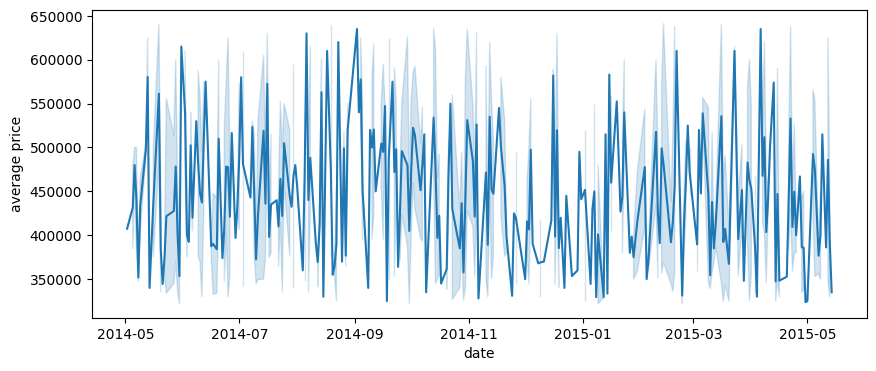

In [40]:
#plot the price changes
plt.figure(figsize=(10, 4))
ax = sns.lineplot(data=df_client, x='date', y='price')
ax.set_ylabel("average price");

Because the price is very volatile during the year, we can smooth the signal to see possible seasonal trends:

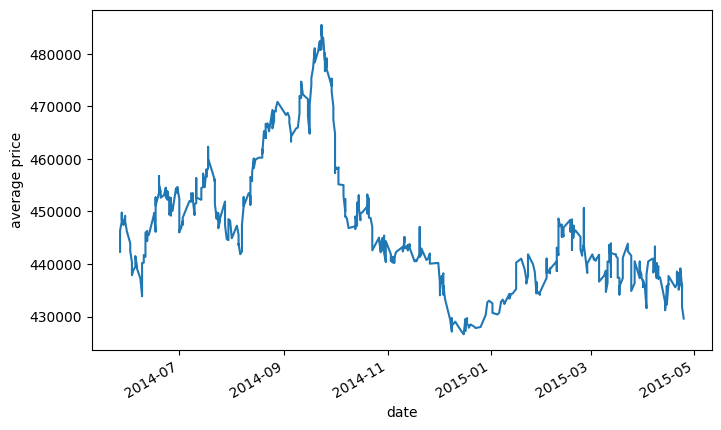

In [41]:
# smooth the signal
def smooth_signal(sr: pd.Series, n=3):
    smoother = np.ones(n) / n
    smoothed = np.correlate(sr.values, smoother, mode='same')     #smoothed
    new_series = pd.Series(smoothed)
    new_series.index = sr.index
    return new_series

n = 70
sr = df_client[['date', 'price']].set_index('date', drop=True).sort_index().squeeze()
sr = smooth_signal(sr, n)
sr[n//2:-n//2].plot(kind='line', ylabel="average price");

We can see that the most unfavorable time for our client to buy a house is from July to November with the peak in October. The most favorable time to buy a house is from December to February. The most favorable month is January. 

* ### conclusion about the right timing

In [42]:
print("The most unfavorable month to buy a house:",  sr[n//2:-n//2].idxmax().month_name())
print("The most favorable month to buy a house:", sr[n//2:-n//2].idxmin().month_name())

The most unfavorable month to buy a house: September
The most favorable month to buy a house: December


## Explore the zipcodes for client's requirements

**research question:** In which zipcodes does the client has a better chance to find a house in the mid range price, near the city center?

* ### do the grouping, aggregating, sorting to get the insight:

In [43]:
cols = ['zipcode', 'price']
df_zipcodes = df_client[cols].groupby('zipcode').agg(['count', 'mean'])
df_zipcodes.columns = df_zipcodes.columns.droplevel(level=0)
df_zipcodes = df_zipcodes.sort_values(['count', 'mean'], ascending=[False, True])
df_zipcodes.columns = ['count', 'mean_price']
df_zipcodes.head(15)

,count,mean_price
zipcode,,
98122,159,494138.006
98056,103,401913.971
98023,71,401789.944
98144,57,425370.158
98055,37,400570.865
98030,31,363401.613
98059,31,404472.581
98112,29,533380.276
98003,20,435091.400


* ### create a rating of zipcodes for the client through binning of certain features

Use **sqft_lot15** as a proxy for "lively" neighborhoods - the less the better i.e. more densely populated, therefore "livelier"

In [44]:
# do rating based on these columns
cols = ['count', 'sqft_lot15', 'price_sq']
df_binned = df_zipcodes.join(df_client.groupby('zipcode').mean())[cols]

# bin these columns in order to enable sorting
for col,bins in zip(df_binned.columns[1:], [3,3]):
    df_binned[col] = pd.cut(df_binned[col], bins=bins, labels=range(1, bins+1))

# sort on multiple binned features
df_binned = df_binned.sort_values(['sqft_lot15', 'price_sq', 'count'], ascending=[True, True, False]).head(10)
df_binned

,count,sqft_lot15,price_sq
zipcode,,,
98122,159,1,2
98144,57,1,2
98112,29,1,3
98102,18,1,3
98109,8,1,3
98119,2,1,3
98056,103,2,1
98055,37,2,1
98059,31,2,1


In [45]:
top_zipcodes = tuple(df_binned.index)
print("advise the client to look in these zipcodes:", top_zipcodes)

advise the client to look in these zipcodes: (98122, 98144, 98112, 98102, 98109, 98119, 98056, 98055, 98059, 98031)


* ### visualize the top zipcodes on the map:

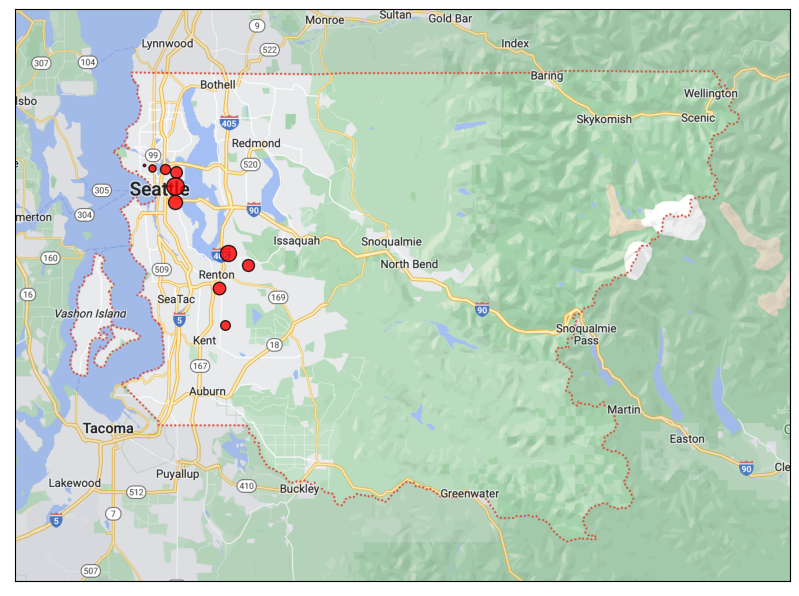

In [46]:
cols = ['zipcode', 'lat', 'long']
df_lat_lon = df[cols].groupby('zipcode').mean()

mask = df_lat_lon.index.isin(top_zipcodes)
df_lat_lon = df_lat_lon[mask].join(df_binned)


def convert(x,y):
    """
    helper function to convert lat,long into the image coordinates
    """
    height, width, _ = im.shape

    x1, x2 = -122.65, -120.95
    y1, y2 = 47.025, 47.87

    xrange = x2 - x1
    px = (x - x1) / xrange

    yrange = y2 - y1
    py = 1 - (y - y1) / yrange

    return (px * width, py * height)


path = "assets/king_county_map.png"

plt.figure(figsize=(10, 10))
im = plt.imread(path)
implot = plt.imshow(im)
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

for zipcode, sr in df_lat_lon.iterrows():
    x,y = convert(x=sr.long, y=sr.lat)
    k = np.log(sr['count']) * 2.5
    plt.plot(x,y, 'or', markersize=k, alpha=0.8, markeredgecolor='k')


<br><br>
# 6. Results of the Analysis of the Hypotheses

* **research question 1:** Are there strong correlations between certain features and the price?
> there are strong to moderate linear correlation between **price** and these features: **gare**, **sqft_living**, **sqft_living15**, **bathrooms**

* **research question 2:** Do the housing prices in the northern part of the county differ from the southern regions of King County?
> - The p-value close to zero shows that the prices do differ

* **research question 3:** Is the proportion of luxury houses dependent on the zipcode?
> - Yes. The proportions distribution confirms that. A chi-squared test can confirm that.

<br>

_recommendations for the client:_

* **research question 4:** When is the best time to buy a house for the client?
> in January


* **research question 5:** In which zipcodes does the client has a better chance to find a house in the mid range price, near the city center?
> Here is the top 10 zipcodes for the client to insure a successful search for a house:<br>
> 98122, 98144, 98112, 98102, 98109, 98119, 98056, 98055, 98059, 98031

<br><br>
# 7. Insights and Recommendations for the Client

1. A linear model can be build with this dataset with a good prediction capabilities
2. The prices differ across the county
3. Concentration of luxury houses is not uniform across the county
4. Despite the absence of a clear seasonal fluctuation in price, the best month to buy a house for the client is January
5. The client can zoom in his search if they look for a house to buy according to the top 10 zip-codes list

**neuefische 2023**